In [1]:
from requests_oauthlib import OAuth1Session
import json
import datetime, time, sys
from abc import ABCMeta, abstractmethod
import pandas as pd
from pandas import Series, DataFrame

In [2]:
CK = '4qzQk73Qw5aJfAQ9dcrmWXkdm'                             # Consumer Key
CS = '9o3yAxnEnkXOnFGGMdFTkTCDM6g6FjLt5RqNJAfzEq2KF8U59W'    # Consumer Secret
AT = '115662117-P1nN3CHlh4bQhrWUMtHiz1xt5oYVt9eg8Ra7yzLq'    # Access Token
AS = 'RrRIYr7l2EtyMQ5qMYIMM9FmxFxEK28pxR6pqRVES5oWX'         # Accesss Token Secert

In [3]:
class TweetsGetter(object):
    __metaclass__ = ABCMeta
 
    def __init__(self):
        self.session = OAuth1Session(CK, CS, AT, AS)
 
    @abstractmethod
    def specifyUrlAndParams(self, keyword):
        '''
        呼出し先 URL、パラメータを返す
        '''
 
    @abstractmethod
    def pickupTweet(self, res_text, includeRetweet):
        '''
        res_text からツイートを取り出し、配列にセットして返却
        '''
 
    @abstractmethod
    def getLimitContext(self, res_text):
        '''
        回数制限の情報を取得 （起動時）
        '''
 
    def collect(self, total = -1, onlyText = False, includeRetweet = False):
        '''
        ツイート取得を開始する
        '''
 
        #----------------
        # 回数制限を確認
        #----------------
        self.checkLimit()
 
        #----------------
        # URL、パラメータ
        #----------------
        url, params = self.specifyUrlAndParams()
        params['include_rts'] = str(includeRetweet).lower()
        # include_rts は statuses/user_timeline のパラメータ。search/tweets には無効
 
        #----------------
        # ツイート取得
        #----------------
        cnt = 0
        unavailableCnt = 0
        while True:
            res = self.session.get(url, params = params)
            if res.status_code == 503:
                # 503 : Service Unavailable
                if unavailableCnt > 10:
                    raise Exception('Twitter API error %d' % res.status_code)
 
                unavailableCnt += 1
                print ('Service Unavailable 503')
                self.waitUntilReset(time.mktime(datetime.datetime.now().timetuple()) + 30)
                continue
 
            unavailableCnt = 0
 
            if res.status_code != 200:
                raise Exception('Twitter API error %d' % res.status_code)
 
            tweets = self.pickupTweet(json.loads(res.text))
            if len(tweets) == 0:
                # len(tweets) != params['count'] としたいが
                # count は最大値らしいので判定に使えない。
                # ⇒  "== 0" にする
                # https://dev.twitter.com/discussions/7513
                break
 
            for tweet in tweets:
                if (('retweeted_status' in tweet) and (includeRetweet is False)):
                    pass
                else:
                    if onlyText is True:
                        yield tweet['text']
                    else:
                        yield tweet
 
                    cnt += 1
                    if cnt % 100 == 0:
                        print ('%d件 ' % cnt)
 
                    if total > 0 and cnt >= total:
                        return
 
            params['max_id'] = tweet['id'] - 1
 
            # ヘッダ確認 （回数制限）
            # X-Rate-Limit-Remaining が入ってないことが稀にあるのでチェック
            if ('X-Rate-Limit-Remaining' in res.headers and 'X-Rate-Limit-Reset' in res.headers):
                if (int(res.headers['X-Rate-Limit-Remaining']) == 0):
                    self.waitUntilReset(int(res.headers['X-Rate-Limit-Reset']))
                    self.checkLimit()
            else:
                print ('not found  -  X-Rate-Limit-Remaining or X-Rate-Limit-Reset')
                self.checkLimit()
 
    def checkLimit(self):
        '''
        回数制限を問合せ、アクセス可能になるまで wait する
        '''
        unavailableCnt = 0
        while True:
            url = "https://api.twitter.com/1.1/application/rate_limit_status.json"
            res = self.session.get(url)
 
            if res.status_code == 503:
                # 503 : Service Unavailable
                if unavailableCnt > 10:
                    raise Exception('Twitter API error %d' % res.status_code)
 
                unavailableCnt += 1
                print ('Service Unavailable 503')
                self.waitUntilReset(time.mktime(datetime.datetime.now().timetuple()) + 30)
                continue
 
            unavailableCnt = 0
 
            if res.status_code != 200:
                raise Exception('Twitter API error %d' % res.status_code)
 
            remaining, reset = self.getLimitContext(json.loads(res.text))
            if (remaining == 0):
                self.waitUntilReset(reset)
            else:
                break
 
    def waitUntilReset(self, reset):
        '''
        reset 時刻まで sleep
        '''
        seconds = reset - time.mktime(datetime.datetime.now().timetuple())
        seconds = max(seconds, 0)
        print ('\n     =====================')
        print ('     == waiting %d sec ==' % seconds)
        print ('     =====================')
        sys.stdout.flush()
        time.sleep(seconds + 10)  # 念のため + 10 秒
 
    @staticmethod
    def bySearch(keyword):
        return TweetsGetterBySearch(keyword)
 
    @staticmethod
    def byUser(screen_name):
        return TweetsGetterByUser(screen_name)
 

In [4]:
class TweetsGetterBySearch(TweetsGetter):
    '''
    キーワードでツイートを検索
    '''
    def __init__(self, keyword):
        super(TweetsGetterBySearch, self).__init__()
        self.keyword = keyword
        
    def specifyUrlAndParams(self):
        '''
        呼出し先 URL、パラメータを返す
        '''
        url = 'https://api.twitter.com/1.1/search/tweets.json'
        params = {'q':self.keyword, 'count':100}
        return url, params
 
    def pickupTweet(self, res_text):
        '''
        res_text からツイートを取り出し、配列にセットして返却
        '''
        results = []
        for tweet in res_text['statuses']:
            results.append(tweet)
 
        return results
 
    def getLimitContext(self, res_text):
        '''
        回数制限の情報を取得 （起動時）
        '''
        remaining = res_text['resources']['search']['/search/tweets']['remaining']
        reset     = res_text['resources']['search']['/search/tweets']['reset']
 
        return int(remaining), int(reset)

In [23]:
def save_tweet(word, since, until):
    created_at = []
    text = []

    # キーワードで取得
    keyword = word + ' AND -filter:retweets AND -filter:replies AND since:' + since + ' AND until:' + until
    getter = TweetsGetter.bySearch(keyword)

    # ユーザーを指定して取得 （screen_name）
    #getter = TweetsGetter.byUser('AbeShinzo')

    cnt = 0
    for tweet in getter.collect(total = 1000000):
        #cnt += 1
        #print ('------ %d' % cnt)
        #print ('{} {} {}'.format(tweet['id'], tweet['created_at'], '@'+tweet['user']['screen_name']))
        #print (tweet['text'])
        created_at.append(tweet['created_at'])
        text.append(tweet['text'])
    
    created_at = Series(created_at)
    text = Series(text)

    #各シリーズをデータフレーム化
    df = pd.concat([created_at, text],axis=1)

    #カラム名
    df.columns=['created_at','text']

    #csvファイルとして保存
    df.to_csv(word + '_' + until + '.csv', sep = '\t',encoding='utf-16')
    
    return df

In [36]:
d_s = datetime.datetime.today() - datetime.timedelta(days=7)
since = d_s.strftime("%Y-%m-%d")
d_u = datetime.datetime.today() - datetime.timedelta(days=0)
until = d_u.strftime("%Y-%m-%d")

In [37]:
YH_df = save_tweet('八幡浜', since, until)
ID_df = save_tweet('飯田市', since, until)

100件 
200件 
300件 
400件 


In [38]:
print(YH_df.shape)
print(ID_df.shape)

(494, 2)
(85, 2)


In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [40]:
from dateutil import parser
YH_df["date"] = YH_df["created_at"].apply(parser.parse)
YH_df["date"] = pd.to_datetime(YH_df["date"])

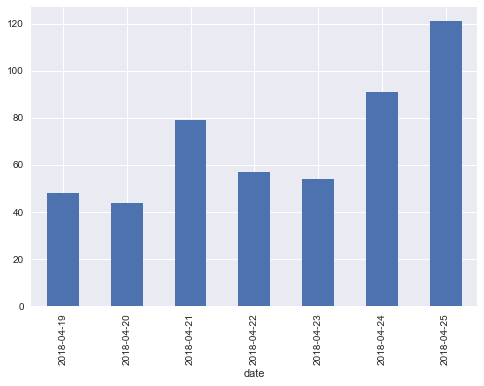

In [41]:
YH_df.groupby(YH_df["date"].dt.date).date.count().plot(kind="bar")
#sns.distplot(YH_df["date"])


In [42]:
YH_df.head(100)

,created_at,text,date
0,Wed Apr 25 23:53:27 +0000 2018,"山本博司 on Twitter: ""ブログを投稿しました：温かなふるさとの皆様との交流（愛媛...",2018-04-25 23:53:27+00:00
1,Wed Apr 25 23:29:15 +0000 2018,愛媛県の八幡浜には、日本一黒い「ブラック商店街」がある。 | TABI LABO https...,2018-04-25 23:29:15+00:00
2,Wed Apr 25 23:24:43 +0000 2018,●グルメ● 和と洋の職人が作りだす「モダン和食」が大人気。中でもおすすめは八幡浜直送天然鮮魚...,2018-04-25 23:24:43+00:00
3,Wed Apr 25 23:21:39 +0000 2018,【愛媛県 八幡浜】シャッター通りのブラックさを逆手にとったかのようなこの取り組み...今では...,2018-04-25 23:21:39+00:00
4,Wed Apr 25 23:12:01 +0000 2018,旅地図ー九州\n2017年6月現在旅した場所。青線が乗った鉄道路線、赤点が途中下車した場所や...,2018-04-25 23:12:01+00:00
5,Wed Apr 25 23:01:20 +0000 2018,愛媛県の八幡浜には、日本一黒い「#ブラック商店街」がある!! \nhttps://t.co/...,2018-04-25 23:01:20+00:00
6,Wed Apr 25 23:00:39 +0000 2018,【速報】全国高校総体 女子１５００ｍ決勝①向井（至学館）4.16.76②倉岡（鹿児島女）4....,2018-04-25 23:00:39+00:00
7,Wed Apr 25 22:22:34 +0000 2018,中学時代の大分出身の教師が八幡浜方面経由で帰省するとか言ってたのを思い出した,2018-04-25 22:22:34+00:00
8,Wed Apr 25 21:37:08 +0000 2018,愛媛県の八幡浜には、日本一黒い「ブラック商店街」がある。 https://t.co/Sb9C...,2018-04-25 21:37:08+00:00
9,Wed Apr 25 21:33:15 +0000 2018,愛媛県の八幡浜には、日本一黒い「ブラック商店街」がある。 https://t.co/AtyF...,2018-04-25 21:33:15+00:00
